# Examine the feature importances on an external dataset

In [1]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

## Helper wrapper around 

In [9]:
def make_regression(noise_columns=0, **kwargs):
    X, y = datasets.make_regression(**kwargs)
    np.random.default_rng(kwargs.get("random_state", 0))
    if noise_columns != 0:
        X = np.append(X, np.random.choice(range(10), (X.shape[0], noise_columns)), axis=1)    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

## Train the model

In [10]:
X_train, X_test, y_train, y_test = make_regression(
    n_samples=3000, 
    noise=1, 
    n_features=10, 
    noise_columns=5, 
    random_state=1
)

model = lgb.LGBMRegressor(objective="regression", verbose=-1).fit(X_train, y_train)
lgb.plot_importance(model, importance_type='gain', max_num_features=30)

NameError: name 'numpy' is not defined

## Trace the tree and compute the gain of each split on the test set

### Helper function to calculate the gain of each node

In [4]:
def node_gain(sum_grad, sum_hess, value):
    return -(2.0 * sum_grad * value + sum_hess * value * value)

### Helper function to trace a singular tree and sum the feature_importance of each feature

In [5]:
def dfs_accumulate(gains, tree, grad, hess, predicted_leaves):
    if 'left_child' not in tree:
        leaf_grad = grad[predicted_leaves == tree['leaf_index']].sum()
        leaf_hess = hess[predicted_leaves == tree['leaf_index']].sum()
        leaf_value = tree['leaf_value']
        leaf_gain = node_gain(leaf_grad, leaf_hess, leaf_value)
        return leaf_grad, leaf_hess, leaf_value, leaf_gain
    else:
        l_grad, l_hess, l_val, l_gain = dfs_accumulate(gains, tree['left_child'], grad, hess, predicted_leaves)
        r_grad, r_hess, r_val, r_gain = dfs_accumulate(gains, tree['right_child'], grad, hess, predicted_leaves)
        sum_grad, sum_hess, value = (l_grad + r_grad, l_hess + r_hess, tree['internal_value'])
        now_gain = node_gain(sum_grad, sum_hess, value) 
        gains[tree['split_feature']] += (l_gain + r_gain) - now_gain
        return sum_grad, sum_hess, value, now_gain

### Run the whole computation, utilizing the exposed ObjectiveFunction class

In [6]:
def compute_out_of_sample_gains(X, y, model, objective):
    booster = model.booster_
    eval_set = lgb.Dataset(X, y).construct()
    fobj = lgb.ObjectiveFunction(objective, {"objective": objective}).init(eval_set)
    score = np.zeros(len(y))    
    model_dump = booster.dump_model()
    
    gains = np.zeros(len(model_dump['feature_names']), dtype=np.float64)
    
    for i, tree in enumerate(model_dump['tree_info']):
        grad, hess = fobj.get_gradients(score)
        score += model.predict(X, num_iteration=1, start_iteration=i)
        predicted_leaves = model.predict(X, num_iteration=1, start_iteration=i, pred_leaf=True)
        dfs_accumulate(gains, tree['tree_structure'], grad, hess, predicted_leaves)

    return {
        feat: value
        for value, feat in sorted(zip(gains, model_dump['feature_names']), key=lambda x: x[0])
    }

oos_gains = compute_out_of_sample_gains(X_test, y_test, model, "regression")

### Examine the plot and deduce that the noise columns are actually harmful, rather than less helpful

In [7]:
oos_gains_harmful = {
    column: value
    for column, value in oos_gains.items()
    if value < 0
}

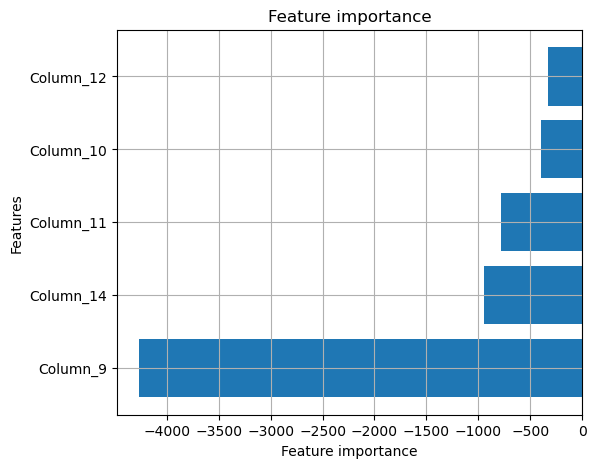

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.barh(list(oos_gains_harmful.keys()), list(oos_gains_harmful.values()))
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.title('Feature importance')
plt.grid(axis='both')
plt.show()